# Learning to Solve Large-Scale Security-Constrained Unit Commitment Problems
Alinson S. Xavier, Feng Qiu, Shabbir Ahmed

Security-Constrained Unit Commitment (SCUC) is a fundamental problem in power systems and electricity markets. In practical settings, SCUC is repeatedly solved via Mixed-Integer Linear Programming, sometimes multiple times per day, with only minor changes in input data. In this work, we propose a number of machine learning (ML) techniques to effectively extract information from previously solved instances in order to significantly improve the computational performance of MIP solvers when solving similar instances in the future. Based on statistical data, we predict redundant constraints in the formulation, good initial feasible solutions and affine subspaces where the optimal solution is likely to lie, leading to significant reduction in problem size. Computational results on a diverse set of realistic and large-scale instances show that, using the proposed techniques, SCUC can be solved on average 12 times faster than conventional methods, with no negative impact on solution quality.

[ArXiv](https://arxiv.org/abs/1902.01697)

# Summary of complex power, impedance, and admittance

<table><tr><th> symbol </th><th> Name </th><th>Complex representation</th></tr>
    <tr><td>$Y$ </td><td> admittance  (inverse impedance) </td><td>  $Y =  G + jB$ </td></tr>
<tr><td>$B$  </td><td> susceptance  </td><td>   </td></tr>
<tr><td>$G$  </td><td>s conductance (real part of admittance) </td><td> </td></tr>
<tr><td>$Z$  </td><td> impedance  </td><td> $Z = R + jX$ </td></tr>
<tr><td>$X$  </td><td>Reactance </td><td>   </td></tr>
<tr><td>$R$  </td><td> Resistance  </td><td>  </td></tr>
<tr><td>$S$  </td><td> Real powerflow approximation from bus 1 to bus 2 in a DC model  </td><td> $S=\frac{\theta_1 - \theta_2}{-{BR}_X}$ </td></tr>
<tr><td>$S$  </td><td> Real powerflow approximation constraint  </td><td>$|S| \leq \text{Rate}_A$ </td></tr>
</table>


## Manipulating a small case

None

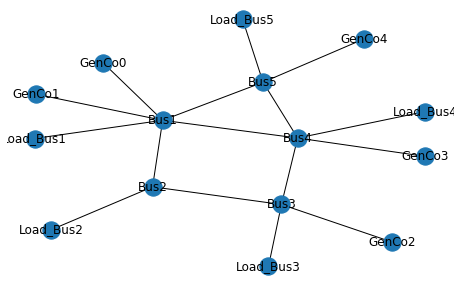

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import psst,os
from psst.case import read_matpower
from psst.model import build_model
from psst.network import create_network
casedir = 'matpower/data'
case5 = read_matpower(os.path.join(casedir,'case5.m'))
generator_df = pd.merge(case5.gen, case5.gencost, left_index=True, right_index=True)
network5 = create_network( case5, prog='neato')
display(network5.draw())
plt.savefig('case5.png')

In [14]:
case5.bus

,TYPE,PD,QD,GS,BS,AREA,VM,VA,BASEKV,ZONE,VMAX,VMIN
Bus1,2,0,0.00,0,0,1,1,0,230,1,1.1,0.9
Bus2,1,300,98.61,0,0,1,1,0,230,1,1.1,0.9
Bus3,2,300,98.61,0,0,1,1,0,230,1,1.1,0.9
Bus4,3,400,131.47,0,0,1,1,0,230,1,1.1,0.9
Bus5,2,0,0.00,0,0,1,1,0,230,1,1.1,0.9


In [15]:
case5.branch

,F_BUS,T_BUS,BR_R,BR_X,BR_B,RATE_A,RATE_B,RATE_C,TAP,SHIFT,BR_STATUS,ANGMIN,ANGMAX
0,Bus1,Bus2,0.00281,0.0281,0.00712,400,400,400,0,0,1,-360,360
1,Bus1,Bus4,0.00304,0.0304,0.00658,0,0,0,0,0,1,-360,360
2,Bus1,Bus5,0.00064,0.0064,0.03126,0,0,0,0,0,1,-360,360
3,Bus2,Bus3,0.00108,0.0108,0.01852,0,0,0,0,0,1,-360,360
4,Bus3,Bus4,0.00297,0.0297,0.00674,0,0,0,0,0,1,-360,360
5,Bus4,Bus5,0.00297,0.0297,0.00674,240,240,240,0,0,1,-360,360


In [18]:
case5.gen

,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME
GenCo0,Bus1,40.00,0,30.0,-30.0,1,100,1,40,0,0,0,0,0,0,0,0,40,0,0,0,40,40,0,0
GenCo1,Bus1,170.00,0,127.5,-127.5,1,100,1,170,0,0,0,0,0,0,0,0,170,0,0,0,170,170,0,0
GenCo2,Bus3,323.49,0,390.0,-390.0,1,100,1,520,0,0,0,0,0,0,0,0,520,0,0,0,520,520,0,0
GenCo3,Bus4,0.00,0,150.0,-150.0,1,100,1,200,0,0,0,0,0,0,0,0,200,0,0,0,200,200,0,0
GenCo4,Bus5,466.51,0,450.0,-450.0,1,100,1,600,0,0,0,0,0,0,0,0,600,0,0,0,600,600,0,0


In [16]:
case5.load

,Bus1,Bus2,Bus3,Bus4,Bus5
0,0.0,300.0,300.0,400.0,0.0


In [13]:
try:
    model5 = build_model(case5, generator_df)
    model5.solve(solver='glpk', verbose=True)
except ValueError as e:
    print(e)
    
model5.results.power_generated

Changed model.MinimumPowerOutput to use within=Reals
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --mipgap 0.01 --write /var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmpfijlgwuz.glpk.raw
 --wglp /var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmpsl06owhx.glpk.glp
 --cpxlp /var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmphxu29uww.pyomo.lp
Reading problem data from '/var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmphxu29uww.pyomo.lp'...
/var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmphxu29uww.pyomo.lp:659: warning: lower bound of variable 'UnitOn(GenCo0_0)' redefined
/var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmphxu29uww.pyomo.lp:659: warning: upper bound of variable 'UnitOn(GenCo0_0)' redefined
106 rows, 87 columns, 244 non-zeros
5 integer variables, all of which are binary
664 lines were read
Writing problem data to '/var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmpsl06owhx.glpk.glp'...
598 lines were written
GLPK Integer Optimize

,GenCo0,GenCo3,GenCo4,GenCo2,GenCo1
0,40.0,0.0,466.505154,323.494846,170.0


# Case 7 (with timepoints)

None

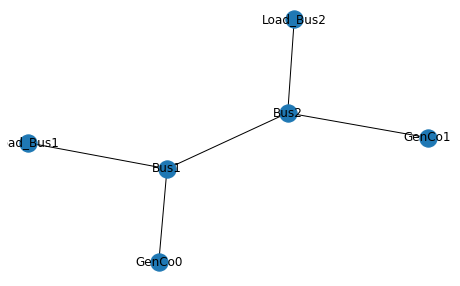

In [7]:
casedir = '../PSST/psst/docs/notebooks/cases'
case7 = read_matpower(os.path.join(casedir,'case7.m'))
generator_df = pd.merge(case7.gen, case7.gencost, left_index=True, right_index=True)
case7.load = pd.read_csv(os.path.join(casedir,'case7.csv'), index_col=0)
network7 = create_network( case7, prog='neato')
display(network7.draw())
plt.savefig('case7.png')

In [194]:
case7.load

,Bus1,Bus2
0,0.0,100.0
1,0.0,100.0
2,0.0,100.0
3,0.0,120.0
4,0.0,120.0
5,0.0,120.0
6,0.0,150.0
7,0.0,150.0
8,0.0,150.0
9,0.0,200.0


In [6]:
from IPython.display import HTML
HTML(generator_df[['PMIN','PMAX']].to_html().replace('\n',''))

,PMIN,PMAX
GenCo0,0,200
GenCo1,0,500


In [9]:
model7 = build_model(case7)
model7.solve(solver='glpk', verbose=True)
model7.results.unit_commitment

Changed model.MinimumPowerOutput to use within=Reals
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --mipgap 0.01 --write /var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmp6c2jklv3.glpk.raw
 --wglp /var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmpp1pvc5m4.glpk.glp
 --cpxlp /var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmp0eoni66g.pyomo.lp
Reading problem data from '/var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmp0eoni66g.pyomo.lp'...
/var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmp0eoni66g.pyomo.lp:5889: warning: lower bound of variable 'UnitOn(GenCo0_0)' redefined
/var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmp0eoni66g.pyomo.lp:5889: warning: upper bound of variable 'UnitOn(GenCo0_0)' redefined
899 rows, 753 columns, 2429 non-zeros
48 integer variables, all of which are binary
5937 lines were read
Writing problem data to '/var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmpp1pvc5m4.glpk.glp'...
5420 lines were written
GLPK Integer O

/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/solver/results.py:42: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  return df.clip_lower(0)


,GenCo1,GenCo0
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


## Which Matpower cases are readable?  Which are convertable to a UC model?

In [20]:

import psst, os
from psst.case import read_matpower
from psst.model import build_model
casedir = 'matpower/data'
generator = {}
for casefile in cases:
    #if casefile[-2:] == '.m':
        try:
            case = read_matpower(os.path.join(casedir, casefile + '.m'))
            generator[casefile] = pd.merge(case.gen, case.gencost, left_index=True, right_index=True)
            print(casefile)
            display(generator[(generator_df['PG'] <0) & (generator_df['PMIN'] <0)])
        except:
            print('Could not parse {}'.format(casefile))

case1888rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0


case1951rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo35,Bus973,-7.47,0.0,0.0,0.0,1.121,100,1,0.0,-8.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,1,0


case2848rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo191,Bus124,-5.91,0.0,0.0,0.0,1.047,100,1,0.0,-7.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,1,0
GenCo192,Bus124,-5.91,0.0,0.0,0.0,1.047,100,1,0.0,-7.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,1,0
GenCo314,Bus1276,-8.00,0.0,0.0,0.0,1.069,100,1,0.0,-8.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,1,0


case3012wp


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0


case3375wp


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0


case6468rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo695,Bus3624,-3.30,0.21,30.0,-10.0,1.021,100,1,40.0,-40.0,0,0,0,0,0,0,0,40.0,0,0,0,40.0,40.0,0,0,2,0,0,2,0,1,0
GenCo696,Bus3624,-3.30,0.21,28.0,-28.0,1.021,100,1,50.0,-50.0,0,0,0,0,0,0,0,50.0,0,0,0,50.0,50.0,0,0,2,0,0,2,0,1,0
GenCo1048,Bus6165,-11.17,0.34,182.0,-252.0,1.044,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0
GenCo1049,Bus6165,-11.17,0.34,182.0,-252.0,1.044,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0
GenCo1050,Bus6165,-11.17,0.34,182.0,-252.0,1.044,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0
GenCo1051,Bus6165,-11.17,0.34,182.0,-252.0,1.044,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0


case6470rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo126,Bus623,-2.11,-8.30,8.30,-8.30,1.049,100,1,8.3,-8.3,0,0,0,0,0,0,0,8.3,0,0,0,8.3,8.3,0,0,2,0,0,2,0,1,0
GenCo1280,Bus6425,-1.97,9.78,18.02,-6.63,1.081,100,1,80.0,-80.0,0,0,0,0,0,0,0,80.0,0,0,0,80.0,80.0,0,0,2,0,0,2,0,1,0
GenCo1281,Bus6426,-1.97,12.93,18.02,-6.63,1.085,100,1,80.0,-80.0,0,0,0,0,0,0,0,80.0,0,0,0,80.0,80.0,0,0,2,0,0,2,0,1,0
GenCo1282,Bus6427,-1.97,12.93,18.02,-6.63,1.085,100,1,80.0,-80.0,0,0,0,0,0,0,0,80.0,0,0,0,80.0,80.0,0,0,2,0,0,2,0,1,0


case6495rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo126,Bus624,-4.03,-8.30,8.3,-8.3,1.039,100,1,8.3,-8.3,0,0,0,0,0,0,0,8.3,0,0,0,8.3,8.3,0,0,2,0,0,2,0,1,0
GenCo429,Bus2290,-4.65,2.94,20.0,-20.0,1.014,100,1,64.0,-64.0,0,0,0,0,0,0,0,64.0,0,0,0,64.0,64.0,0,0,2,0,0,2,0,1,0
GenCo1060,Bus6124,-4.82,3.68,182.0,-252.0,1.094,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0
GenCo1061,Bus6124,-4.82,3.68,182.0,-252.0,1.094,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0
GenCo1062,Bus6124,-4.82,3.68,182.0,-252.0,1.094,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0
GenCo1063,Bus6124,-4.82,3.68,182.0,-252.0,1.094,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0


case6515rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo126,Bus624,-4.11,-8.3,8.3,-8.3,1.047,100,1,8.3,-8.3,0,0,0,0,0,0,0,8.3,0,0,0,8.3,8.3,0,0,2,0,0,2,0,1,0


In [10]:
import psst
from psst.case import read_matpower
from psst.network import create_network
import pandas as pd

cases = """case1888rte
case1951rte
case2848rte
case3012wp
case3375wp
case6468rte
case6470rte
case6495rte
case6515rte""".split('\n')

from IPython.display import display, Markdown
matpower = {}
scuc = {}
network = {}

## Generate Xavier 2019 Table 2

In [29]:
def transform_neg_pmin_to_load( case ):
    neg_pmin = case.gen['PMIN']<0
    buses = case.gen[neg_pmin][['GEN_BUS', 'PMIN']].set_index('GEN_BUS')
    case.load[buses.index] = case.load[buses.index] - buses['PMIN']
    generator_df = pd.merge(case.gen, case.gencost, left_index=True, right_index=True)
    generator_df.loc[neg_pmin,'PMAX'] = generator_df.loc[neg_pmin,'PMAX'] - generator_df.loc[neg_pmin,'PMIN']
    generator_df.loc[neg_pmin,'PMIN'] = 0
    return build_model(case, generator_df)

table2 = pd.DataFrame(index=cases, columns=['Buses','Units','Lines'])
table2.index.name='Instances'
for case in cases:
    print(case)
    matpower[case] = read_matpower('matpower/data/{}.m'.format(case))
    table2.loc[case] = dict( Buses=len(matpower[case].bus_name),
                             Units=len(matpower[case].gen_name),
                             Lines=len(matpower[case].branch_name))
table2

case1888rte
case1951rte
case2848rte
case3012wp
case3375wp
case6468rte
case6470rte
case6495rte
case6515rte


,Buses,Units,Lines
Instances,,,
case1888rte,1888,298,2531
case1951rte,1951,392,2596
case2848rte,2848,548,3776
case3012wp,3012,502,3572
case3375wp,3374,596,4161
case6468rte,6468,1296,9000
case6470rte,6470,1331,9005
case6495rte,6495,1373,9019
case6515rte,6515,1389,9037


![Table2-Xavier.png](Table2-Xavier.png)

# Causal model of data generating process



| Parameter Names | Definition |  Source of Parameter values |
|------------|------------|--------------------|
| $g\in G$   | generators | given by each case |
| $b\in B$   | Buses      | given by each case |
| $\ell \in L$ | Branches (Transmission lines) | given by each case |
| $t\in [1,\ldots,T]$  | hourly time points ($T=24$) | given by each case |
| $c_g^0,c_g^1,\ldots,c^k_g,c^s_g$ | Cost of producing each additional MW of power within the piecewise interval $k$ with minimum cost $c_g^0$ and startup cost $c_g^s$ | $\alpha_gc_g^0,\alpha_gc_g^1,\ldots,\alpha_gc_g^k,\alpha_gc_g^s$ |
|$\mu_t$  | Mean of hourly load variation | Obtained from PJM January 2017 loads |
|$\sigma_t$ | Standard deviation of hourly load variation | obtained from PJM January 2017 loads|
|$d_b$ | Original per bus load percentage | `case.load.divide(case.load.sum(axis=1))` |
| $\gamma_t$ | Original hourly variation in system load $D_{t+1}/D_t$ | Obtained from PJM January 2017 loads |
| $C$ | System-wide capacity | $C = \sum_g \text{PMAX}_g$ |

| Variable | Definition |  Parametric Distribution of Random Variables |
|----------|------------|-----------------------------------|
| $\alpha_g$ | Daily change in bid prices per generator | $\alpha_g \sim  U[0.95, 1.05]$ |
| $\beta_b$  | Variation in geographical (bus) load distribution | $\beta_b  \sim  U[0.90, 1.10]$ |
| $\gamma_t'$ | Hourly variation in system load $D_{t+1}/D_t$| $\gamma_t'  \sim  N(\mu_t, \sigma_t)$ |
| $\rho$ | Peak system load ($60\% \text{ of } C = \sum_g \text{PMAX}_g) \pm 7.5\%$) | $\rho  \sim  U[0.6\times 0.92C, 0.6\times 0.1075 C]$ |

![Xavier2019.png](Xavier2019.png)

#  Training and Test Samples

During training 300 variations of each of the original instances were generated and solved to optimality. We considered four sources of uncertainty: 

1. uncertain production and startup costs; 
2. uncertain geographical load distribution; 
3. uncertain peak system load; and 
4. uncertain temporal load profile. 

The precise randomization scheme is described below. The specific parameters were chosen based on our analysis of publicly available bid and hourly demand data from [PJM (2018)](https://www.pjm.com/markets-and-operations/energy.aspx), corresponding to the month of January, 2017. 

1. **Production and startup costs**. In the original instances, the production cost for each generator $g\in G$ is modelled as a convex piecewise-linear function described by the parameters $c^0_g$, the cost of producing the minimum amount of power, and $c^1_g,\ldots ,c^k_g$, the costs of producing each additional MW of power within the piecewise interval $k$. In addition, each generator has a startup cost $c^s_g$. In our data analysis, we observed that the daily changes in bid prices rarely exceeded $\pm 5\%$. Therefore, random numbers $\alpha_g$ were independently drawn from the uniform distribution in the interval $\left[0.95,1.05\right]$, for each generator $g\in G$, and the costs of $g$ were linearly scaled by this factor. That is, the costs for generator $g$ were set to $\alpha_g c^0_g, \alpha_g c^1_g, \ldots  \alpha_g c^k_g, \alpha_g c^s_g$. 

In [21]:
import numpy as np
np.random.seed(20191120)
def get_production_and_startup_costs( case, low=0.95, high=1.05 ):
    alpha = np.random.uniform(low=low, high=high, size=len(case.gen_name))
    cols = ['STARTUP'] + ['COST_{}'.format(k) for k in range(case.gencost.loc['GenCo0', 'NCOST'] + 1)]
    gencost = case.gencost.copy()
    gencost[cols] = gencost[cols].multiply(alpha, axis=0)
    return gencost
get_production_and_startup_costs(matpower[case] )

,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo0,2,0.0,0,2,0.0,2.098991,0.0
GenCo1,2,0.0,0,2,0.0,1.905209,0.0
GenCo2,2,0.0,0,2,0.0,1.918524,0.0
GenCo3,2,0.0,0,2,0.0,1.035478,0.0
GenCo4,2,0.0,0,2,0.0,2.039641,0.0
...,...,...,...,...,...,...,...
GenCo1384,2,0.0,0,2,0.0,0.976094,0.0
GenCo1385,2,0.0,0,2,0.0,0.968691,0.0
GenCo1386,2,0.0,0,2,0.0,0.983891,0.0
GenCo1387,2,0.0,0,2,0.0,1.043462,0.0


2. **Geographical load distribution**. In the original instances, each bus $b\in B$ is responsible for a certain percentage $d_b$ of the total system load. To generate variations of these parameters, random numbers $\beta_b$ were independently drawn from the uniform distribution in the interval $\left[0.90, 1.10\right]$. The percentages $d_b$ were then linearly scaled by the $\beta$ factors and later normalized. More precisely, the demand for each bus $b\in B$ was set to $\frac{\beta_b d_b}{\sum_{i\in b} \beta_i}$.

Note that the normalization constant described above is incorrect. It should be:

$$\frac{\beta_b d_b}{\sum_{i\in b} \beta_i d_i}$$


In [22]:
def get_geographical_load_distribution( case, low=0.9, high=1.1 ):
    """"""
    beta= np.random.uniform(low=low, high=high, size=len(case.bus_name))
    load_distribution = case.load.multiply(beta, axis=1)
    normalized_load_distribution = load_distribution/np.squeeze(load_distribution.sum(axis=1))
    return normalized_load_distribution
total_load = np.squeeze(matpower[case].load.sum(axis=1))
get_geographical_load_distribution( matpower[case] )*total_load

,Bus1,Bus2,Bus3,Bus4,Bus5,Bus6,Bus7,Bus8,Bus9,Bus10,Bus11,Bus12,Bus13,Bus14,Bus15,Bus16,Bus17,Bus18,Bus19,Bus20,Bus21,Bus22,Bus23,Bus24,Bus25,Bus26,Bus27,Bus28,Bus29,Bus30,Bus31,Bus32,Bus33,Bus34,Bus35,Bus36,Bus37,Bus38,Bus39,Bus40,Bus41,Bus42,Bus43,Bus44,Bus45,Bus46,Bus47,Bus48,Bus49,Bus50,Bus51,Bus52,Bus53,Bus54,Bus55,Bus56,Bus57,Bus58,Bus59,Bus60,Bus61,Bus62,Bus63,Bus64,Bus65,Bus66,Bus67,Bus68,Bus69,Bus70,Bus71,Bus72,Bus73,Bus74,Bus75,Bus76,Bus77,Bus78,Bus79,Bus80,Bus81,Bus82,Bus83,Bus84,Bus85,Bus86,Bus87,Bus88,Bus89,Bus90,Bus91,Bus92,Bus93,Bus94,Bus95,Bus96,Bus97,Bus98,Bus99,Bus100,Bus101,Bus102,Bus103,Bus104,Bus105,Bus106,Bus107,Bus108,Bus109,Bus110,Bus111,Bus112,Bus113,Bus114,Bus115,Bus116,Bus117,Bus118,Bus119,Bus120,Bus121,Bus122,Bus123,Bus124,Bus125,Bus126,Bus127,Bus128,Bus129,Bus130,Bus131,Bus132,Bus133,Bus134,Bus135,Bus136,Bus137,Bus138,Bus139,Bus140,Bus141,Bus142,Bus143,Bus144,Bus145,Bus146,Bus147,Bus148,Bus149,Bus150,Bus151,Bus152,Bus153,Bus154,Bus155,Bus156,Bus157,Bus158,Bus159,Bus160,Bus161,Bus162,Bus163,Bus164,Bus165,Bus166,Bus167,Bus168,Bus169,Bus170,Bus171,Bus172,Bus173,Bus174,Bus175,Bus176,Bus177,Bus178,Bus179,Bus180,Bus181,Bus182,Bus183,Bus184,Bus185,Bus186,Bus187,Bus188,Bus189,Bus190,Bus191,Bus192,Bus193,Bus194,Bus195,Bus196,Bus197,Bus198,Bus199,Bus200,Bus201,Bus202,Bus203,Bus204,Bus205,Bus206,Bus207,Bus208,Bus209,Bus210,Bus211,Bus212,Bus213,Bus214,Bus215,Bus216,Bus217,Bus218,Bus219,Bus220,Bus221,Bus222,Bus223,Bus224,Bus225,Bus226,Bus227,Bus228,Bus229,Bus230,Bus231,Bus232,Bus233,Bus234,Bus235,Bus236,Bus237,Bus238,Bus239,Bus240,Bus241,Bus242,Bus243,Bus244,Bus245,Bus246,Bus247,Bus248,Bus249,Bus250,Bus251,Bus252,Bus253,Bus254,Bus255,Bus256,Bus257,Bus258,Bus259,Bus260,Bus261,Bus262,Bus263,Bus264,Bus265,Bus266,Bus267,Bus268,Bus269,Bus270,Bus271,Bus272,Bus273,Bus274,Bus275,Bus276,Bus277,Bus278,Bus279,Bus280,Bus281,Bus282,Bus283,Bus284,Bus285,Bus286,Bus287,Bus288,Bus289,Bus290,Bus291,Bus292,Bus293,Bus294,Bus295,Bus296,Bus297,Bus298,Bus299,Bus300,Bus301,Bus302,Bus303,Bus304,Bus305,Bus306,Bus307,Bus308,Bus309,Bus310,Bus311,Bus312,Bus313,Bus314,Bus315,Bus316,Bus317,Bus318,Bus319,Bus320,Bus321,Bus322,Bus323,Bus324,Bus325,Bus326,Bus327,Bus328,Bus329,Bus330,Bus331,Bus332,Bus333,Bus334,Bus335,Bus336,Bus337,Bus338,Bus339,Bus340,Bus341,Bus342,Bus343,Bus344,Bus345,Bus346,Bus347,Bus348,Bus349,Bus350,Bus351,Bus352,Bus353,Bus354,Bus355,Bus356,Bus357,Bus358,Bus359,Bus360,Bus361,Bus362,Bus363,Bus364,Bus365,Bus366,Bus367,Bus368,Bus369,Bus370,Bus371,Bus372,Bus373,Bus374,Bus375,Bus376,Bus377,Bus378,Bus379,Bus380,Bus381,Bus382,Bus383,Bus384,Bus385,Bus386,Bus387,Bus388,Bus389,Bus390,Bus391,Bus392,Bus393,Bus394,Bus395,Bus396,Bus397,Bus398,Bus399,Bus400,Bus401,Bus402,Bus403,Bus404,Bus405,Bus406,Bus407,Bus408,Bus409,Bus410,Bus411,Bus412,Bus413,Bus414,Bus415,Bus416,Bus417,Bus418,Bus419,Bus420,Bus421,Bus422,Bus423,Bus424,Bus425,Bus426,Bus427,Bus428,Bus429,Bus430,Bus431,Bus432,Bus433,Bus434,Bus435,Bus436,Bus437,Bus438,Bus439,Bus440,Bus441,Bus442,Bus443,Bus444,Bus445,Bus446,Bus447,Bus448,Bus449,Bus450,Bus451,Bus452,Bus453,Bus454,Bus455,Bus456,Bus457,Bus458,Bus459,Bus460,Bus461,Bus462,Bus463,Bus464,Bus465,Bus466,Bus467,Bus468,Bus469,Bus470,Bus471,Bus472,Bus473,Bus474,Bus475,Bus476,Bus477,Bus478,Bus479,Bus480,Bus481,Bus482,Bus483,Bus484,Bus485,Bus486,Bus487,Bus488,Bus489,Bus490,Bus491,Bus492,Bus493,Bus494,Bus495,Bus496,Bus497,Bus498,Bus499,...,Bus6017,Bus6018,Bus6019,Bus6020,Bus6021,Bus6022,Bus6023,Bus6024,Bus6025,Bus6026,Bus6027,Bus6028,Bus6029,Bus6030,Bus6031,Bus6032,Bus6033,Bus6034,Bus6035,Bus6036,Bus6037,Bus6038,Bus6039,Bus6040,Bus6041,Bus6042,Bus6043,Bus6044,Bus6045,Bus6046,Bus6047,Bus6048,Bus6049,Bus6050,Bus6051,Bus6052,Bus6053,Bus6054,Bus6055,Bus6056,Bus6057,Bus6058,Bus6059,Bus6060,Bus6061,Bus6062,Bus6063,Bus6064,Bus6065,Bus6066,Bus6067,Bus6068,Bus6069,Bus6070,Bus6071,Bus6072,Bus6073,Bus6074,Bus6075,Bus6076,Bus6077,Bus6078,Bus6079,Bus6080,Bus6081,Bus6082,Bus6083,Bus6084,Bus6085,Bus6086,Bus6087,Bus6088,Bus6089,Bus6090,Bus6091,Bus6092,Bu

In [181]:
matpower[case].load


,Bus1,Bus2,Bus3,Bus4,Bus5,Bus6,Bus7,Bus8,Bus9,Bus10,Bus11,Bus12,Bus13,Bus14,Bus15,Bus16,Bus17,Bus18,Bus19,Bus20,Bus21,Bus22,Bus23,Bus24,Bus25,Bus26,Bus27,Bus28,Bus29,Bus30,Bus31,Bus32,Bus33,Bus34,Bus35,Bus36,Bus37,Bus38,Bus39,Bus40,Bus41,Bus42,Bus43,Bus44,Bus45,Bus46,Bus47,Bus48,Bus49,Bus50,Bus51,Bus52,Bus53,Bus54,Bus55,Bus56,Bus57,Bus58,Bus59,Bus60,Bus61,Bus62,Bus63,Bus64,Bus65,Bus66,Bus67,Bus68,Bus69,Bus70,Bus71,Bus72,Bus73,Bus74,Bus75,Bus76,Bus77,Bus78,Bus79,Bus80,Bus81,Bus82,Bus83,Bus84,Bus85,Bus86,Bus87,Bus88,Bus89,Bus90,Bus91,Bus92,Bus93,Bus94,Bus95,Bus96,Bus97,Bus98,Bus99,Bus100,Bus101,Bus102,Bus103,Bus104,Bus105,Bus106,Bus107,Bus108,Bus109,Bus110,Bus111,Bus112,Bus113,Bus114,Bus115,Bus116,Bus117,Bus118,Bus119,Bus120,Bus121,Bus122,Bus123,Bus124,Bus125,Bus126,Bus127,Bus128,Bus129,Bus130,Bus131,Bus132,Bus133,Bus134,Bus135,Bus136,Bus137,Bus138,Bus139,Bus140,Bus141,Bus142,Bus143,Bus144,Bus145,Bus146,Bus147,Bus148,Bus149,Bus150,Bus151,Bus152,Bus153,Bus154,Bus155,Bus156,Bus157,Bus158,Bus159,Bus160,Bus161,Bus162,Bus163,Bus164,Bus165,Bus166,Bus167,Bus168,Bus169,Bus170,Bus171,Bus172,Bus173,Bus174,Bus175,Bus176,Bus177,Bus178,Bus179,Bus180,Bus181,Bus182,Bus183,Bus184,Bus185,Bus186,Bus187,Bus188,Bus189,Bus190,Bus191,Bus192,Bus193,Bus194,Bus195,Bus196,Bus197,Bus198,Bus199,Bus200,Bus201,Bus202,Bus203,Bus204,Bus205,Bus206,Bus207,Bus208,Bus209,Bus210,Bus211,Bus212,Bus213,Bus214,Bus215,Bus216,Bus217,Bus218,Bus219,Bus220,Bus221,Bus222,Bus223,Bus224,Bus225,Bus226,Bus227,Bus228,Bus229,Bus230,Bus231,Bus232,Bus233,Bus234,Bus235,Bus236,Bus237,Bus238,Bus239,Bus240,Bus241,Bus242,Bus243,Bus244,Bus245,Bus246,Bus247,Bus248,Bus249,Bus250,Bus251,Bus252,Bus253,Bus254,Bus255,Bus256,Bus257,Bus258,Bus259,Bus260,Bus261,Bus262,Bus263,Bus264,Bus265,Bus266,Bus267,Bus268,Bus269,Bus270,Bus271,Bus272,Bus273,Bus274,Bus275,Bus276,Bus277,Bus278,Bus279,Bus280,Bus281,Bus282,Bus283,Bus284,Bus285,Bus286,Bus287,Bus288,Bus289,Bus290,Bus291,Bus292,Bus293,Bus294,Bus295,Bus296,Bus297,Bus298,Bus299,Bus300,Bus301,Bus302,Bus303,Bus304,Bus305,Bus306,Bus307,Bus308,Bus309,Bus310,Bus311,Bus312,Bus313,Bus314,Bus315,Bus316,Bus317,Bus318,Bus319,Bus320,Bus321,Bus322,Bus323,Bus324,Bus325,Bus326,Bus327,Bus328,Bus329,Bus330,Bus331,Bus332,Bus333,Bus334,Bus335,Bus336,Bus337,Bus338,Bus339,Bus340,Bus341,Bus342,Bus343,Bus344,Bus345,Bus346,Bus347,Bus348,Bus349,Bus350,Bus351,Bus352,Bus353,Bus354,Bus355,Bus356,Bus357,Bus358,Bus359,Bus360,Bus361,Bus362,Bus363,Bus364,Bus365,Bus366,Bus367,Bus368,Bus369,Bus370,Bus371,Bus372,Bus373,Bus374,Bus375,Bus376,Bus377,Bus378,Bus379,Bus380,Bus381,Bus382,Bus383,Bus384,Bus385,Bus386,Bus387,Bus388,Bus389,Bus390,Bus391,Bus392,Bus393,Bus394,Bus395,Bus396,Bus397,Bus398,Bus399,Bus400,Bus401,Bus402,Bus403,Bus404,Bus405,Bus406,Bus407,Bus408,Bus409,Bus410,Bus411,Bus412,Bus413,Bus414,Bus415,Bus416,Bus417,Bus418,Bus419,Bus420,Bus421,Bus422,Bus423,Bus424,Bus425,Bus426,Bus427,Bus428,Bus429,Bus430,Bus431,Bus432,Bus433,Bus434,Bus435,Bus436,Bus437,Bus438,Bus439,Bus440,Bus441,Bus442,Bus443,Bus444,Bus445,Bus446,Bus447,Bus448,Bus449,Bus450,Bus451,Bus452,Bus453,Bus454,Bus455,Bus456,Bus457,Bus458,Bus459,Bus460,Bus461,Bus462,Bus463,Bus464,Bus465,Bus466,Bus467,Bus468,Bus469,Bus470,Bus471,Bus472,Bus473,Bus474,Bus475,Bus476,Bus477,Bus478,Bus479,Bus480,Bus481,Bus482,Bus483,Bus484,Bus485,Bus486,Bus487,Bus488,Bus489,Bus490,Bus491,Bus492,Bus493,Bus494,Bus495,Bus496,Bus497,Bus498,Bus499,...,Bus6017,Bus6018,Bus6019,Bus6020,Bus6021,Bus6022,Bus6023,Bus6024,Bus6025,Bus6026,Bus6027,Bus6028,Bus6029,Bus6030,Bus6031,Bus6032,Bus6033,Bus6034,Bus6035,Bus6036,Bus6037,Bus6038,Bus6039,Bus6040,Bus6041,Bus6042,Bus6043,Bus6044,Bus6045,Bus6046,Bus6047,Bus6048,Bus6049,Bus6050,Bus6051,Bus6052,Bus6053,Bus6054,Bus6055,Bus6056,Bus6057,Bus6058,Bus6059,Bus6060,Bus6061,Bus6062,Bus6063,Bus6064,Bus6065,Bus6066,Bus6067,Bus6068,Bus6069,Bus6070,Bus6071,Bus6072,Bus6073,Bus6074,Bus6075,Bus6076,Bus6077,Bus6078,Bus6079,Bus6080,Bus6081,Bus6082,Bus6083,Bus6084,Bus6085,Bus6086,Bus6087,Bus6088,Bus6089,Bus6090,Bus6091,Bus6092,Bu

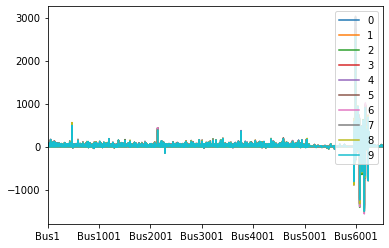

In [170]:
geo_load = pd.DataFrame()
for i in range(10):
    geo_load[i] = geographical_load_distribution( matpower[case] ).loc[0]


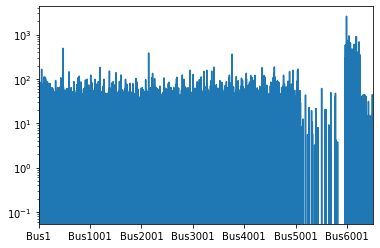

In [175]:
geo_load[i].plot(legend=False)
plt.yscale('log')
plt.show()

3. **Peak system load and temporal load profile.** For simplicity, assume $T=\left\{1,\ldots,24\right\}$. Let
$D_1, \ldots ,D_{24}$ denote the system-wide load during each hour of operation, and let $\gamma_t=\frac{D_{t+1}}{D_t}$ for $t= 1,\ldots , 23$, be the hourly variation in system load. In order to generate realistic distribution for these parameters, we analyzed hourly demand data from [PJM (2018)](https://www.pjm.com/markets-and-operations/energy.aspx). More specifically, we computed the mean $\mu_t$ and variance
$\sigma^2_t$ of each parameter $\gamma_t$, for $t= 1,\ldots ,23$.

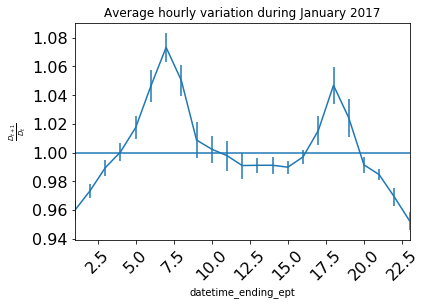

In [24]:
import numpy as np

hrl = pd.read_csv('hrl_load_estimated.csv',infer_datetime_format=True, parse_dates=['datetime_beginning_utc', 
                                                                                    'datetime_beginning_ept',
                                                                                    'datetime_ending_utc', 
                                                                                    'datetime_ending_ept',])
gamma = hrl.groupby(['load_area',hrl['datetime_ending_ept'].dt.hour]).mean().unstack(0).pct_change() + 1
hourly_variation = gamma.mean(axis=1).dropna().to_frame('$\mu$')
hourly_variation['$\sigma$'] = gamma.std(axis=1).dropna()
hourly_variation['$\mu$'].plot(legend=False,
                               #xticks=hourly_variation.index,
                               kind="line",
                               rot=45,
                               fontsize=16,
                               yerr=hourly_variation['$\sigma$'])
plt.ylabel(r'$\frac{D_{t+1}}{D_t}$')
plt.title(r'Average hourly variation during January 2017')
plt.axhline(y=1)


 To generate instance variations, random numbers
 ${\gamma'}_t$ were then independently drawn from the Gaussian distribution $N(\mu_t, \sigma^2_t)$. Note that the
 $\gamma'$ parameters only specify the variation in system load from hour to hour, and are not sufficient to determine
 $D_1,\ldots ,D_{24}$. Therefore, in addition to these parameters, a random number $\rho$, corresponding to the peak system load $\max\{D_1,\ldots D_{24}\}$, was also generated. In the original instances, the peak system load is always $60\%$ of the total capacity. Based on our data analysis, we observed that the actual peak load rarely deviates more than $\pm 7.5\%$ from the day-ahead forecast. Therefore, to generate instance variations,$\rho$ was sampled from the uniform distribution in the interval $\left[0.6 \times 0.925C, 0.6\times 1.075C\right]$, where $C$ is the total capacity. Note that the $\rho$ and $\gamma'$ are now sufficient to construct $D_1,\ldots D_{24}$. Figure 1 shows a sample of some artificially generated load profiles.
 

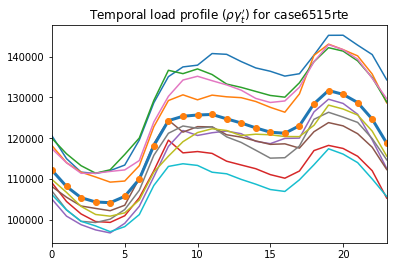

In [25]:
def get_peak_system_load( case,  capacity_pct=0.6, deviation=0.075 ):
    capacity = case.gen['PMAX'].sum()
    rho = np.random.uniform( low = capacity_pct*(1-deviation)*capacity, 
                            high = capacity_pct*(1+deviation)*capacity
                            )
    return rho
def get_hourly_load( case, hourly_variation_mean, hourly_variation_std ):
    gamma = np.random.normal(loc= hourly_variation_mean,
                            scale= hourly_variation_std)
    return gamma

def get_temporal_load_profile( case, gamma_prime, rho ):
    system_wide_load = [rho] + [0 for i in range(23)]
    t = 0
    for g_t in gamma_prime:
        system_wide_load[t+1] = system_wide_load[t]*g_t
        t += 1
    return system_wide_load

system_wide_load = pd.DataFrame()
for i in range(10):
    rho = get_peak_system_load( matpower[case] )
    gamma = get_hourly_load( matpower[case], hourly_variation[r'$\mu$'], hourly_variation[r'$\sigma$'] )
    system_wide_load[i] = get_temporal_load_profile( matpower[case], gamma, rho)
system_wide_load.plot(legend=False)
system_wide_load.mean(axis=1).plot(linewidth=3)
system_wide_load.mean(axis=1).plot(style='o')
plt.title(r"Temporal load profile ($\rho\gamma_t'$) for {}".format(matpower[case].name))
plt.show()

In [31]:
def get_bus_loads( case, gamma, rho, T=24 ):
    
    geo_load = get_geographical_load_distribution( case )
    bus_load = pd.DataFrame(columns=geo_load.columns, index=[t for t in range(T)])
    for t, gamma_t in enumerate(get_temporal_load_profile( case, gamma, rho)):
        bus_load.loc[t] = geo_load.loc[0]*gamma_t
    return bus_load

rho = get_peak_system_load( matpower[case] )
gamma = get_hourly_load( matpower[case], hourly_variation[r'$\mu$'], hourly_variation[r'$\sigma$'] )
bus_load = get_bus_loads( matpower[case], gamma, rho )
bus_load.to_csv('{}_instance_{}.csv'.format(case, 0))
bus_load



Bus1 Bus2     Bus3     Bus4     Bus5     Bus6     Bus7     Bus8     Bus9  \
0     0    0  14.8153  45.7929  12.6303  14.0193  2.12068   16.377  15.2262   
1     0    0  14.1804  43.8302   12.089  13.4185  2.02979  15.6751  14.5737   
2     0    0   13.882  42.9079  11.8346  13.1361  1.98708  15.3453   14.267   
3     0    0  13.7291  42.4353  11.7042  12.9914  1.96519  15.1762  14.1098   
4     0    0  13.7184  42.4024  11.6952  12.9813  1.96367  15.1645  14.0989   
5     0    0  14.1584  43.7624  12.0703  13.3977  2.02665  15.6509  14.5511   
6     0    0  14.8023  45.7526  12.6192   14.007  2.11882  16.3626  15.2129   
7     0    0  16.1645   49.963  13.7805   15.296   2.3138  17.8684  16.6128   
8     0    0  17.0209    52.61  14.5106  16.1064  2.43639  18.8151   17.493   
9     0    0   17.182  53.1081   14.648  16.2589  2.45945  18.9932  17.6586   
10    0    0  17.1299  52.9469  14.6035  16.2095  2.45199  18.9355   17.605   
11    0    0  17.1585  53.0355  14.6279  16.2366  2.45609  18.9672  17.6344   
12    0    0  17.0253  52.6236  14.5143  16.1105  2.43702  18.8199  17.4975   
13    0    0  16.8683  52.1383  14.3805   15.962  2.41454  18.6464  17.3361   
14    0    0  16.8026  51.9352  14.3245  15.8998  2.40514  18.5737  17.2686   
15    0    0  16.6712  51.5291  14.2125  15.7755  2.38633  18.4285  17.1335   
16    0    0  16.7105  51.6507   14.246  15.8127  2.39196   18.472   17.174   
17    0    0  17.0767  52.7825  14.5582  16.1592  2.44437  18.8768  17.5503   
18    0    0   17.847  55.1635  15.2149  16.8881  2.55464  19.7283   18.342   
19    0    0  18.2035  56.2655  15.5188  17.2255  2.60567  20.1224  18.7084   
20    0    0  18.0303  55.7301  15.3712  17.0616  2.58088  19.9309  18.5304   
21    0    0  17.7799  54.9562  15.1577  16.8247  2.54504  19.6541  18.2731   
22    0    0  17.4764  54.0179  14.8989  16.5374  2.50159  19.3186  17.9611   
23    0    0  16.3929  50.6691  13.9753  15.5122   2.3465  18.1209  16.8476   

   Bus10    Bus11 Bus12 Bus13    Bus14 Bus15    Bus16    Bus17 Bus18  \
0      0  35.3223     0     0  68.2814     0  15.2499  11.8828     0   
1      0  33.8084     0     0  65.3549     0  14.5963  11.3735     0   
2      0  33.0969     0     0  63.9796     0  14.2891  11.1342     0   
3      0  32.7324     0     0  63.2749     0  14.1317  11.0115     0   
4      0   32.707     0     0  63.2259     0  14.1208   11.003     0   
5      0  33.7561     0     0  65.2538     0  14.5737  11.3559     0   
6      0  35.2912     0     0  68.2214     0  15.2365  11.8723     0   
7      0  38.5389     0     0  74.4995     0  16.6386  12.9649     0   
8      0  40.5807     0     0  78.4464     0  17.5201  13.6518     0   
9      0  40.9648     0     0  79.1891     0   17.686   13.781     0   
10     0  40.8405     0     0  78.9487     0  17.6323  13.7392     0   
11     0  40.9088     0     0  79.0808     0  17.6618  13.7622     0   
12     0  40.5911     0     0  78.4667     0  17.5247  13.6553     0   
13     0  40.2168     0     0   77.743     0   17.363  13.5294     0   
14     0  40.0601     0     0  77.4402     0  17.2954  13.4767     0   
15     0  39.7469     0     0  76.8346     0  17.1602  13.3713     0   
16     0  39.8407     0     0   77.016     0  17.2007  13.4029     0   
17     0  40.7137     0     0  78.7036     0  17.5776  13.6965     0   
18     0  42.5503     0     0   82.254     0  18.3705  14.3144     0   
19     0  43.4003     0     0   83.897     0  18.7375  14.6003     0   
20     0  42.9873     0     0  83.0987     0  18.5592  14.4614     0   
21     0  42.3904     0     0  81.9448     0  18.3015  14.2606     0   
22     0  41.6666     0     0  80.5457     0   17.989  14.0171     0   
23     0  39.0835     0     0  75.5523     0  16.8738  13.1481     0   

       Bus19    Bus20    Bus21    Bus22    Bus23    Bus24    Bus25    Bus26  \
0   0.927541  6.13229   7.7693  20.6414  24.2529  16.4138  53.6996  13.9089   
1   0.887787  5.86947  7.43632  19.7567  23.2135  15.7103  51.3981  

# Generated loads and costs for all Xavier cases

In [231]:
for case in cases:
    os.makedirs(case,exist_ok=True)
    matpower[case] = read_matpower('matpower/data/{}.m'.format(case))
    print(case)
    #display(matpower[case].load)
    for i in range(300):
        generator_cost = generate_costs( matpower[case] )
        rho = peak_system_load( matpower[case] )
        gamma = hourly_load( matpower[case], hourly_variation[r'$\mu$'], hourly_variation[r'$\sigma$'] )
        bus_load = generate_bus_loads( matpower[case], gamma, rho )
        bus_load.to_csv('{}/{}_load_{:03d}.csv'.format(case, case, i))
        generator_cost.to_csv('{}/{}_gencost_{:03d}.csv'.format(case, case, i))

    

case1888rte
case1951rte
case2848rte
case3012wp
case3375wp
case6468rte
case6470rte
case6495rte
case6515rte


During test, 50 additional variations of each original instance were generated, using the same randomization scheme outline above, but with a different random seed. These instances were then solved to optimality using four different strategies: without any machine-learning $\bf\tt{(zero)}$, using only the transmission oracle $\tt{(tr)}$, using transmission and warm-start oracles $\tt{(tr-ws)}$ and finally using only the transmission and affine subspace detection oracles $\tt{(tr-aff)}$. For strategies $\tt{zero}$, $\tt{tr}$ and $\tt{tr-ws}$, CPLEX was configured to use a relative MIP gap tolerance of $0.1\%$. For strategy $\tt{tr-aff}$, this tolerance was reduced to $0.05\%$, to compensate for eventual inaccurate predictions.

## Reproduce negative PMIN problem

In [9]:
!git clone https://github.com/MATPOWER/matpower.git

fatal: destination path 'matpower' already exists and is not an empty directory.


In [40]:

import psst
from psst.case import read_matpower
from psst.model import build_model

case = read_matpower('matpower/data/case1888rte.m')
print(case.gen.loc['GenCo32', 'PMIN'])
try:
    model = build_model(case)
except ValueError as e:
    print(e)

-8.0
Changed model.MinimumPowerOutput to use within=Reals


ERROR:pyomo.core:Constructing component 'ComputeProductionCosts' from data=None failed:
ValueError: 'ComputeProductionCosts[GenCo32,0]' does not have a list of domain points that is non-decreasing


ERROR: Constructing component 'ComputeProductionCosts' from data=None failed:
    ValueError: 'ComputeProductionCosts[GenCo32,0]' does not have a list of
    domain points that is non-decreasing
'ComputeProductionCosts[GenCo32,0]' does not have a list of domain points that is non-decreasing


In [5]:
dir(matpower[case])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_attributes',
 '_filename',
 '_read_festiv',
 '_read_matpower',
 'baseMVA',
 'branch',
 'branch_name',
 'bus',
 'bus_name',
 'gen',
 'gen_name',
 'gen_status',
 'gencost',
 'load',
 'name',
 'period',
 'version']

In [50]:
case = 'case3012wp'
scuc[case] = read_matpower('matpower/data/{}.m'.format(case))
table = '|Instance|Buses|Units|Lines|\n|----|----|----|---|\n'

table += '|{}|{}|{}|{}|\n'.format(case, len(scuc[case].bus_name),
                                             len(scuc[case].gen_name),
                                             len(scuc[case].branch_name))
#case_network = create_network(case)
#case_network
Markdown(table)

|Instance|Buses|Units|Lines|
|----|----|----|---|
|case3012wp|3012|502|3572|


In [37]:
case.bus


,TYPE,PD,QD,GS,BS,AREA,VM,VA,BASEKV,ZONE,VMAX,VMIN
Bus1,1,5.8,-5.8,0,0,1,1.031493,-43.492413,225,1,1.08889,0.888889
Bus2,1,0.0,0.0,0,0,1,1.052035,-1.699896,380,1,1.10263,1.048410
Bus3,1,142.5,-13.4,0,0,1,1.044838,-18.267388,225,1,1.08444,1.004440
Bus4,1,0.0,0.0,0,0,1,1.064605,-20.592316,150,1,1.10667,0.900000
Bus5,1,32.8,-5.3,0,0,1,1.061605,-24.974129,225,1,1.08889,0.933333
...,...,...,...,...,...,...,...,...,...,...,...,...
Bus1822,1,330.0,-90.0,0,0,1,1.101104,-36.284610,380,1,1.10526,1.039470
Bus1823,1,137.7,-21.3,0,0,1,1.042640,-27.908000,225,1,1.08889,0.933333
Bus1824,1,137.5,-21.2,0,0,1,1.042636,-27.907674,225,1,1.08889,0.933333
Bus1825,1,356.3,-41.8,0,0,1,1.048838,-26.553688,380,1,1.10526,1.039470
